In [2]:
!pip install transformers datasets torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
from transformers import AdamW, get_scheduler
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [4]:
data = pd.read_csv('/content/drive/MyDrive/processed_scrapped_jobs.csv')

In [5]:
data.head()

,Category,Description
0,Data Scientist,locations uk europe africa uk london bae syste...
1,Data Scientist,head data science london days week office per ...
2,Data Scientist,senior data scientist human motion tracking po...
3,Data Scientist,join industry leader technology data scientist...
4,Data Scientist,senior data scientist salary depending experie...


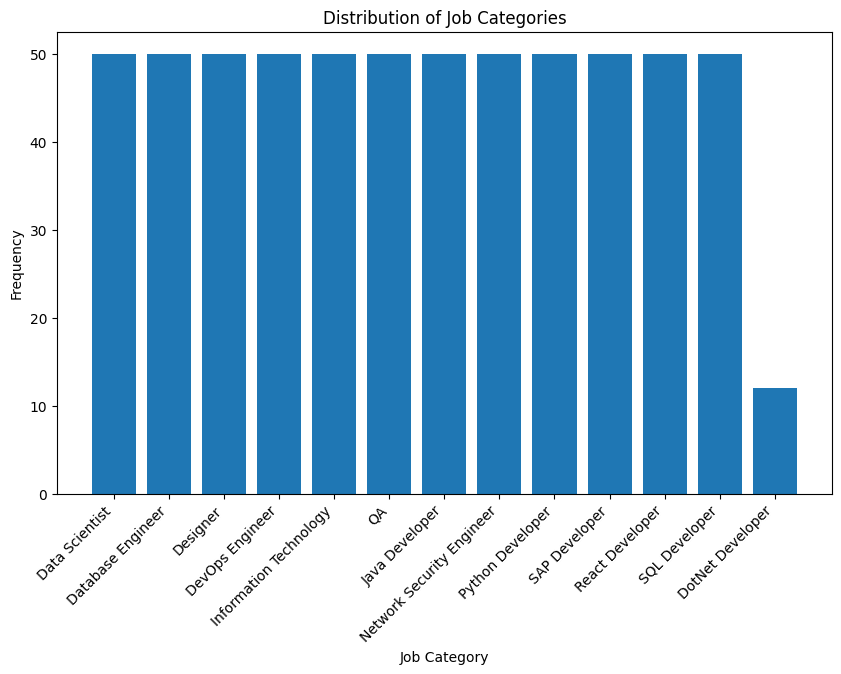

In [6]:
# @title Distribution of Job Categories

import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
category_counts = data['Category'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel("Job Category")
plt.ylabel("Frequency")
plt.title("Distribution of Job Categories")
_ = plt.xticks(rotation=45, ha='right')

In [7]:
data=data.dropna()
data = data.drop_duplicates()

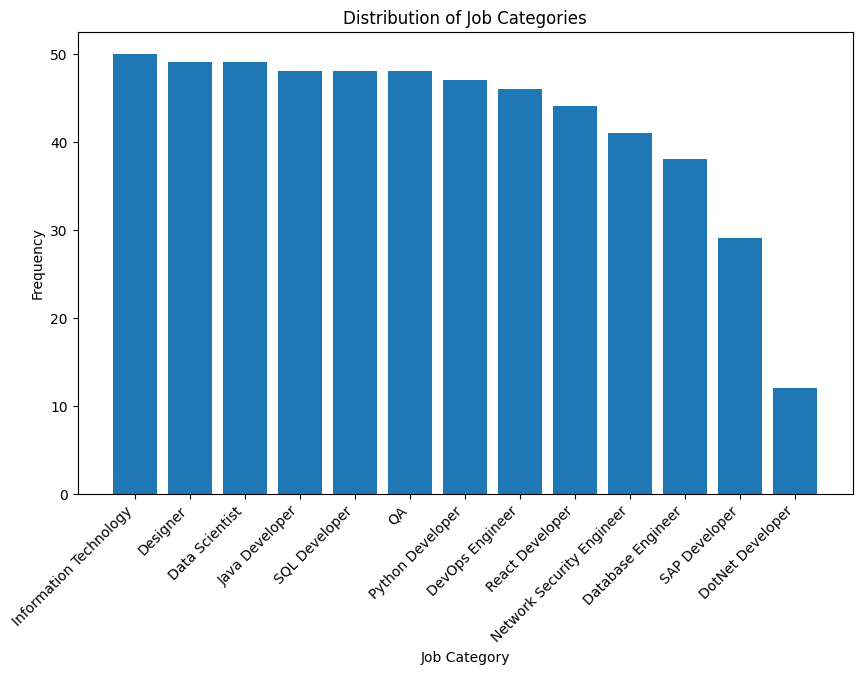

In [8]:
category_counts = data['Category'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel("Job Category")
plt.ylabel("Frequency")
plt.title("Distribution of Job Categories")
_ = plt.xticks(rotation=45, ha='right')

In [9]:
texts = data['Description'].tolist()
labels = data['Category'].tolist()

In [10]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [11]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, encoded_labels, test_size=0.2, random_state=42)

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

In [14]:
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3  # Number of training steps
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Epoch 2: 100%|██████████| 28/28 [00:06<00:00,  4.37it/s, loss=1.02]


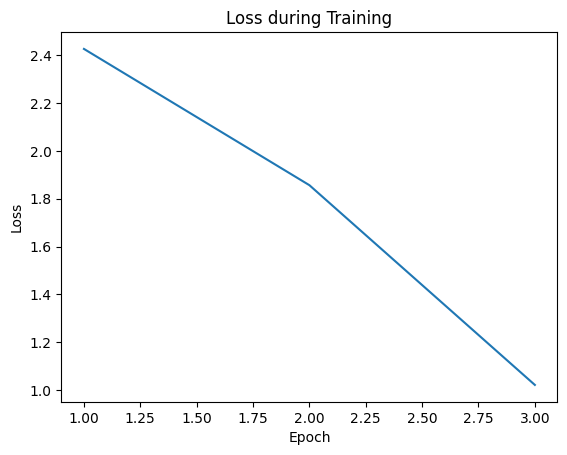

In [16]:
model.train()
losses=[]
for epoch in range(3):  # Number of epochs
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {key: val.to(device) for key, val in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
    losses.append(loss.item())

plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")
plt.show()

In [17]:
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

print(classification_report(true_labels, predictions, target_names=label_encoder.classes_))

                           precision    recall  f1-score   support

           Data Scientist       0.75      0.90      0.82        10
        Database Engineer       0.00      0.00      0.00        16
                 Designer       0.70      0.88      0.78         8
          DevOps Engineer       0.82      0.75      0.78        12
         DotNet Developer       0.00      0.00      0.00         2
   Information Technology       0.33      0.80      0.47        10
           Java Developer       0.80      0.67      0.73         6
Network Security Engineer       0.75      0.75      0.75         4
         Python Developer       0.57      0.57      0.57         7
                       QA       0.88      0.88      0.88         8
          React Developer       0.80      0.57      0.67         7
            SAP Developer       1.00      1.00      1.00         7
            SQL Developer       0.71      0.92      0.80        13

                 accuracy                           0.67    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
model.save_pretrained('/content/drive/MyDrive/JobClassifier')
tokenizer.save_pretrained('/content/drive/MyDrive/JobClassifier')

('/content/drive/MyDrive/JobClassifier/tokenizer_config.json',
 '/content/drive/MyDrive/JobClassifier/special_tokens_map.json',
 '/content/drive/MyDrive/JobClassifier/vocab.txt',
 '/content/drive/MyDrive/JobClassifier/added_tokens.json')

In [19]:
model_path = '/content/drive/MyDrive/JobClassifier'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

# Example inference
text = "design coordinator east midlands design coordinator leading privatelyowned contractor searching design coordinator join growing operations team delivering design build projects across midlands excellent opportunity design coordinator join highly successful contractor delivering commercial education mod multiroom leisure sports projects ranging role generally responsible supporting two li"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
outputs = model(**inputs)
predicted_label = torch.argmax(outputs.logits, dim=1).item()
print(f'Predicted Label: {label_encoder.inverse_transform([predicted_label])[0]}')

Predicted Label: Designer
